In [155]:
from typing import Sequence, Optional, Iterator

import clingo
import clingraph.clingo_utils
from clingraph import Factbase, compute_graphs


In [156]:

def solve(programs,
          ctl: Optional[clingo.Control] = None,
          parts=(('base', ()),),
          context=None,
          report=False,
          report_models=True,
          report_result=True,
          symbol_sep=' ',
          model_sep='\n'
          ) -> Iterator[Sequence[clingo.Symbol]]:
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, context=context)
    with ctl.solve(yield_=True) as solve_handle:
        models = 0
        for model in solve_handle:
            symbols = sorted(model.symbols(shown=True))
            if report and report_models:
                print("Answer {}:".format(model.number), end=' ')
                print("{",
                      symbol_sep.join(map(str, symbols)), "}", sep=symbol_sep, end=model_sep)
            models += 1
            yield symbols
        if report and report_result:
            solve_result = solve_handle.get()
            print(solve_result, end='')
            if solve_result.satisfiable:
                print(" {}{}".format(models, '' if solve_result.exhausted else '+'))
            else:
                print()


def draw_graph(programs,
               ctl: Optional[clingo.Control] = None,
               parts=(('base', ()),)):
    fb = Factbase()
    if ctl is None:
        ctl = clingo.Control()
        ctl.configuration.solve.models = 0
    ctl.add('base', [], '\n'.join(programs))
    ctl.ground(parts, clingraph.clingo_utils.ClingraphContext())
    with ctl.solve(yield_=True) as solve_handle:
        for model in solve_handle:
            fb.add_model(model)
            break
    return compute_graphs(fb)

In [157]:
graph_encoding = """

node(U) :- edge((U,V)).
node(V) :- edge((U,V)).

attr(node, L, label, L) :- pos_literal(L).
attr(node, N, label, @concat("not ", P)) :- neg_literal(N), pos_neg(P,N).
attr(node, N, fontname, "fira-sans") :- node(N).
attr(edge, E, fontname, "fira-sans") :- edge(E).

attr(node, L, style, filled) :- neg_literal(L).
attr(node, L, fontcolor, white) :- neg_literal(L).
attr(node, L, color, black) :- neg_literal(L).

node(Rule) :- rule(Rule).
rule(R) :- fact(R).
attr(node, R, width, L+1) :- rule(R), L = #count { F : edge((R, F)) }.

attr(edge, E, dir, forward) :- edge(E).
attr(node, Rule, shape, box) :- rule(Rule).

pos_literal(P) :- pos_neg(P, N).
neg_literal(N) :- pos_neg(P, N).

"""

In [158]:
example_1_graph_str = """

pos_neg(h, -h).

fact(r1).
attr(node, r1, label, "h :-.").
edge((h, r1)).

"""

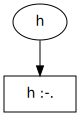

In [159]:
example_1_graph = draw_graph([example_1_graph_str, graph_encoding])['default']
example_1_graph

In [160]:
example_2_graph_str = """

pos_neg(h, -h).
pos_neg(a, -a).
pos_neg(b, -b).

fact(r1).
attr(node, r1, label, "h :-.").
edge((h, r1)).

rule(r2).
attr(node, r2, label, "a :- b.").
edge((a, r2)).
edge((r2, b)).


"""

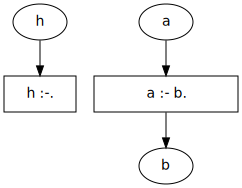

In [161]:
example_2_graph = draw_graph([example_2_graph_str, graph_encoding])['default']
example_2_graph

In [162]:
example_3_graph_str = """

pos_neg(h, -h).
pos_neg(a, -a).
pos_neg(b, -b).

fact(r1).
attr(node, r1, label, "h :-.").
edge((h, r1)).

rule(r2).
attr(node, r2, label, "a :- b.").
edge((a, r2)).
edge((r2, b)).


rule(r3).
attr(node, r3, label, "a :- h.").
edge((a, r3)).
edge((r3, h)).



"""

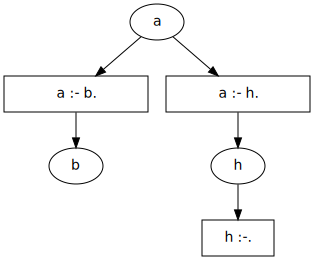

In [163]:
example_3_graph = draw_graph([example_3_graph_str, graph_encoding])['default']
example_3_graph

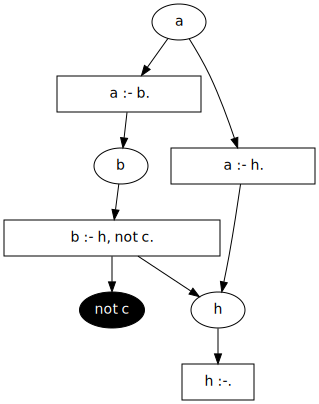

In [164]:
example_4_graph_str = """

pos_neg(h, -h).
pos_neg(a, -a).
pos_neg(b, -b).
pos_neg(c, -c).

fact(r1).
attr(node, r1, label, "h :-.").
edge((h, r1)).

rule(r2).
attr(node, r2, label, "a :- b.").
edge((a, r2)).
edge((r2, b)).


rule(r3).
attr(node, r3, label, "a :- h.").
edge((a, r3)).
edge((r3, h)).

rule(r4).
attr(node, r4, label, "b :- h, not c.").
edge((b, r4)).
edge((r4, h)).
edge((r4, -c)).


"""
example_4_graph = draw_graph([example_4_graph_str, graph_encoding])['default']
example_4_graph

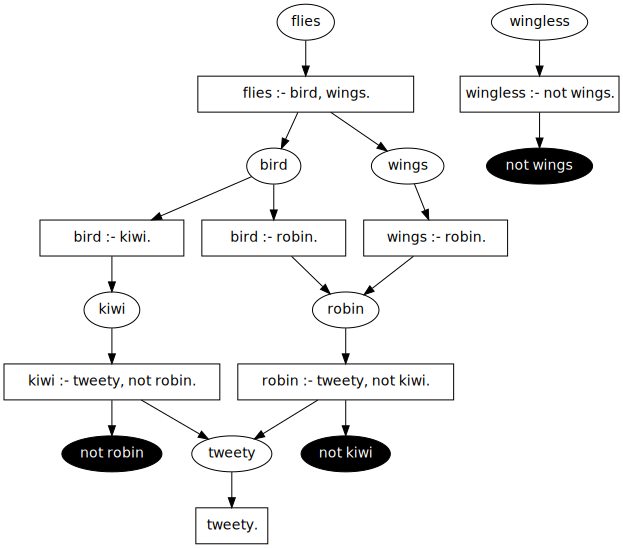

In [165]:
common = """

pos_literal(wings; bird; flies; kiwi; wingless; robin; tweety).
neg_literal(-wings; -bird; -flies; -kiwi; -wingless; -robin; -tweety).
pos_neg(wings, -wings).
pos_neg(bird, -bird).
pos_neg(flies, -flies).
pos_neg(kiwi, -kiwi).
pos_neg(wingless, -wingless).
pos_neg(robin, -robin).
pos_neg(tweety, -tweety).

"""
bird_primal_graph = """

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

rule(r2).
attr(node, r2, label, "robin :- tweety, not kiwi.").
edge((robin, r2)).
edge((r2, tweety)).
edge((r2, -kiwi)).

rule(r3).
attr(node, r3, label, "kiwi :- tweety, not robin.").
edge((kiwi, r3)).
edge((r3, tweety)).
edge((r3, -robin)).

rule(r4).
attr(node, r4, label, "wings :- robin.").
edge((wings, r4)).
edge((r4, robin)).

rule(r5).
attr(node, r5, label, "wingless :- not wings.").
edge((wingless, r5)).
edge((r5, -wings)).

rule(r6).
attr(node, r6, label, "bird :- robin.").
edge((bird, r6)).
edge((r6, robin)).

rule(r7).
attr(node, r7, label, "bird :- kiwi.").
edge((bird, r7)).
edge((r7, kiwi)).

rule(r8).
attr(node, r8, label, "flies :- bird, wings.").
edge((flies, r8)).
edge((r8, bird)).
edge((r8, wings)).


"""

primal_graph = draw_graph([bird_primal_graph, common, graph_encoding])['default']
primal_graph

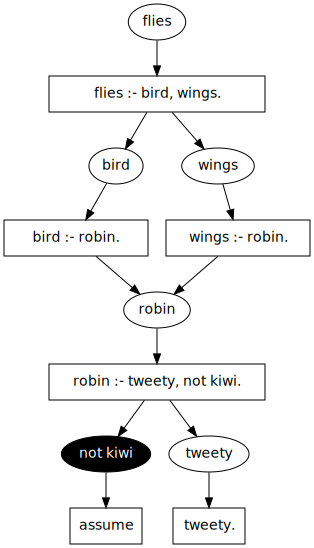

In [166]:
bird_residue_graph_1 = """

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

rule(r2).
attr(node, r2, label, "robin :- tweety, not kiwi.").
edge((robin, r2)).
edge((r2, tweety)).
edge((r2, -kiwi)).


rule(r4).
attr(node, r4, label, "wings :- robin.").
edge((wings, r4)).
edge((r4, robin)).


rule(r6).
attr(node, r6, label, "bird :- robin.").
edge((bird, r6)).
edge((r6, robin)).

rule(r8).
attr(node, r8, label, "flies :- bird, wings.").
edge((flies, r8)).
edge((r8, bird)).
edge((r8, wings)).



rule(d4).
attr(node, d4, label, "assume").
edge((-kiwi, d4)).

"""

residue_graph_1 = draw_graph([bird_residue_graph_1, common, graph_encoding])['default']
residue_graph_1

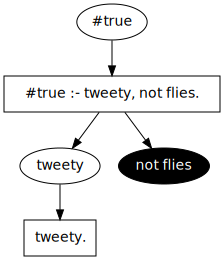

In [167]:
query_2_1_primal = """

node(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

"""

query_2_1_graph = draw_graph([query_2_1_primal, common, graph_encoding])['default']
query_2_1_graph

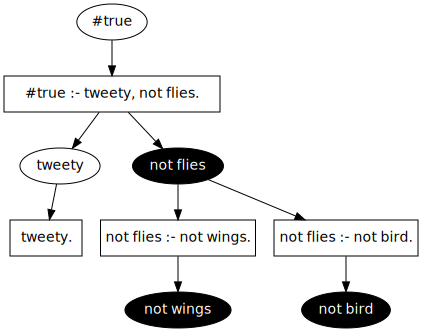

In [168]:
query_2_2_primal = """

node(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

"""

query_2_2_dual = """

rule(d8).
attr(node, d8, label, "not flies :- not bird.").
edge((-flies, d8)).
edge((d8, -bird)).

rule(d9).
attr(node, d9, label, "not flies :- not wings.").
edge((-flies, d9)).
edge((d9, -wings)).

"""

query_2_2_graph = draw_graph([query_2_2_primal, query_2_2_dual, common, graph_encoding])['default']
query_2_2_graph

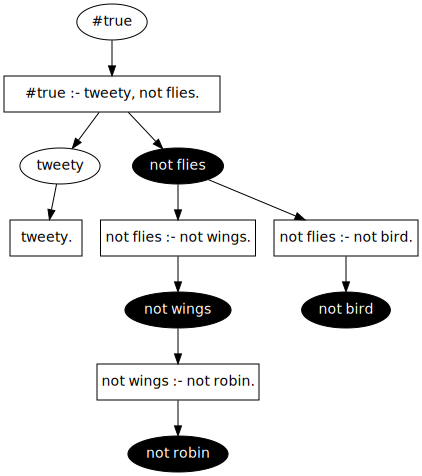

In [169]:
query_2_3_primal = """

node(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

"""

query_2_3_dual = """

rule(d8).
attr(node, d8, label, "not flies :- not bird.").
edge((-flies, d8)).
edge((d8, -bird)).

rule(d9).
attr(node, d9, label, "not flies :- not wings.").
edge((-flies, d9)).
edge((d9, -wings)).

rule(d5).
attr(node, d5, label, "not wings :- not robin.").
edge((-wings, d5)).
edge((d5, -robin)).

"""

query_2_3_graph = draw_graph([query_2_3_primal, query_2_3_dual, common, graph_encoding])['default']
query_2_3_graph

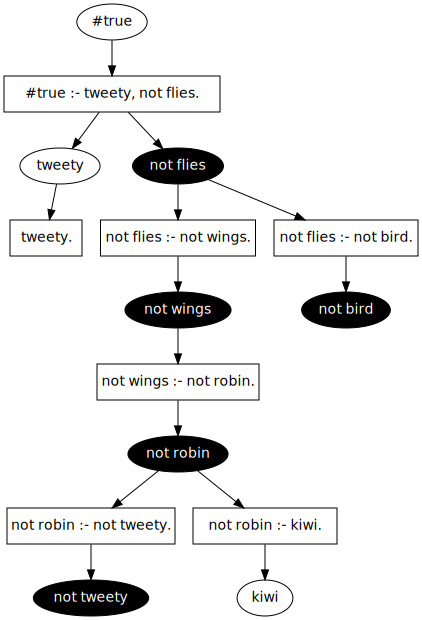

In [170]:
query_2_4_primal = """

node(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

"""

query_2_4_dual = """

rule(d8).
attr(node, d8, label, "not flies :- not bird.").
edge((-flies, d8)).
edge((d8, -bird)).

rule(d9).
attr(node, d9, label, "not flies :- not wings.").
edge((-flies, d9)).
edge((d9, -wings)).

rule(d5).
attr(node, d5, label, "not wings :- not robin.").
edge((-wings, d5)).
edge((d5, -robin)).

rule(d1).
attr(node, d1, label, "not robin :- not tweety.").
edge((-robin, d1)).
edge((d1, -tweety)).

rule(d2).
attr(node, d2, label, "not robin :- kiwi.").
edge((-robin, d2)).
edge((d2, kiwi)).

"""

query_2_4_graph = draw_graph([query_2_4_primal, query_2_4_dual, common, graph_encoding])['default']
query_2_4_graph

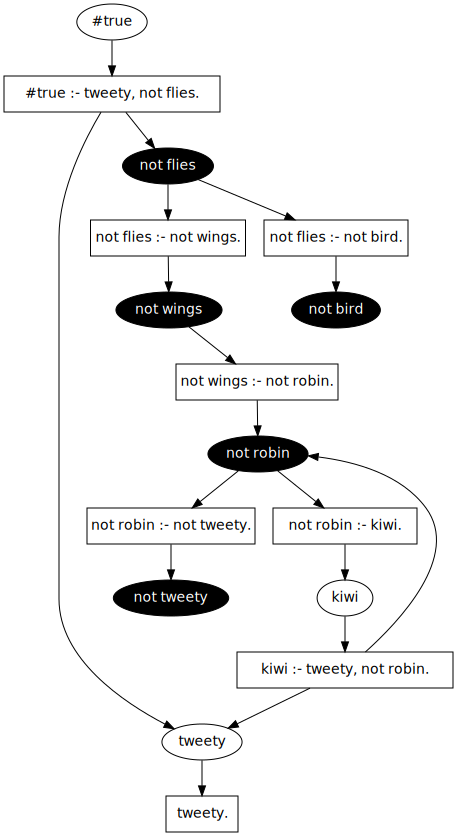

In [171]:
query_2_5_primal = """

node(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).

fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

rule(r3).
attr(node, r3, label, "kiwi :- tweety, not robin.").
edge((kiwi, r3)).
edge((r3, tweety)).
edge((r3, -robin)).

"""

query_2_5_dual = """

rule(d8).
attr(node, d8, label, "not flies :- not bird.").
edge((-flies, d8)).
edge((d8, -bird)).

rule(d9).
attr(node, d9, label, "not flies :- not wings.").
edge((-flies, d9)).
edge((d9, -wings)).

rule(d5).
attr(node, d5, label, "not wings :- not robin.").
edge((-wings, d5)).
edge((d5, -robin)).

rule(d1).
attr(node, d1, label, "not robin :- not tweety.").
edge((-robin, d1)).
edge((d1, -tweety)).

rule(d2).
attr(node, d2, label, "not robin :- kiwi.").
edge((-robin, d2)).
edge((d2, kiwi)).

"""

query_2_5_graph = draw_graph([query_2_5_primal, query_2_5_dual, common, graph_encoding])['default']
query_2_5_graph

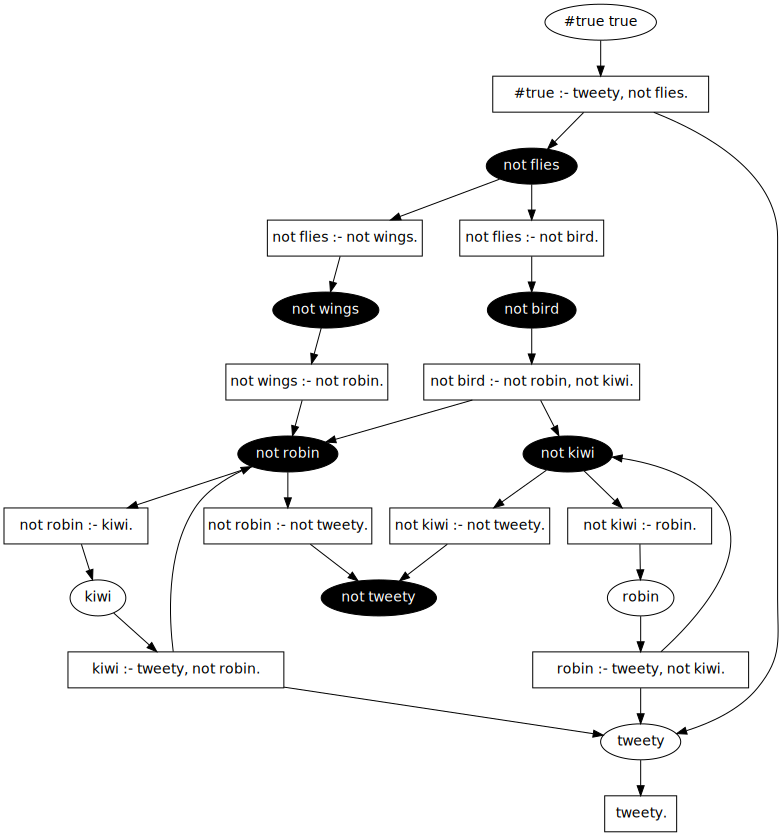

In [172]:
query_2_ff_primal = """

pos_literal(true).
attr(node, true, label, "#true").

rule(q1).
attr(node, q1, label, "#true :- tweety, not flies.").
edge((true, q1)).
edge((q1, tweety)).
edge((q1, -flies)).


fact(r1).
attr(node, r1, label, "tweety.").
edge((tweety, r1)).

rule(r2).
attr(node, r2, label, "robin :- tweety, not kiwi.").
edge((robin, r2)).
edge((r2, tweety)).
edge((r2, -kiwi)).

rule(r3).
attr(node, r3, label, "kiwi :- tweety, not robin.").
edge((kiwi, r3)).
edge((r3, tweety)).
edge((r3, -robin)).

"""

query_2_ff_dual = """

rule(d1).
attr(node, d1, label, "not robin :- not tweety.").
edge((-robin, d1)).
edge((d1, -tweety)).

rule(d2).
attr(node, d2, label, "not robin :- kiwi.").
edge((-robin, d2)).
edge((d2, kiwi)).

rule(d3).
attr(node, d3, label, "not kiwi :- not tweety.").
edge((-kiwi, d3)).
edge((d3, -tweety)).

rule(d4).
attr(node, d4, label, "not kiwi :- robin.").
edge((-kiwi, d4)).
edge((d4, robin)).

rule(d5).
attr(node, d5, label, "not wings :- not robin.").
edge((-wings, d5)).
edge((d5, -robin)).

rule(d7).
attr(node, d7, label, "not bird :- not robin, not kiwi.").
edge((-bird, d7)).
edge((d7, -robin)).
edge((d7, -kiwi)).

rule(d8).
attr(node, d8, label, "not flies :- not bird.").
edge((-flies, d8)).
edge((d8, -bird)).

rule(d9).
attr(node, d9, label, "not flies :- not wings.").
edge((-flies, d9)).
edge((d9, -wings)).

"""
query_2_ff_graph = draw_graph([query_2_ff_primal, query_2_ff_dual, common, graph_encoding])['default']
query_2_ff_graph